<a href="https://colab.research.google.com/github/Shawn1303/Artificial-Intelligence/blob/main/Hw1/Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


All student names in group: Shawn Zhu, Benson Chen

I understand that my submission needs to be my own group's work: SZ, BC

I understand that ChatGPT / Copilot / other AI tools are not allowed: SZ, BC

---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [ ]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2637, done.
remote: Counting objects: 100% (754/754), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 2637 (delta 466), reused 712 (delta 436), pack-reused 1883
Receiving objects: 100% (2637/2637), 283.93 MiB | 40.19 MiB/s, done.
Resolving deltas: 100% (1634/1634), done.
/content/CS7320-AI/Search
empty_2_maze.txt	  loops_maze.txt		     maze_helper.py   small_maze.txt
empty_maze.txt		  Maze_BFS_vs_A_Star.ipynb	     Maze.ipynb       wall_maze.txt
Explore_heuristics.ipynb  Maze_Example-Animation_full.ipynb  medium_maze.txt
large_maze.txt		  Maze_Example-Animation.ipynb	     open_maze.txt
L_maze.txt		  Maze_Example.ipynb		     README.md


In [ ]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)

with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [ ]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

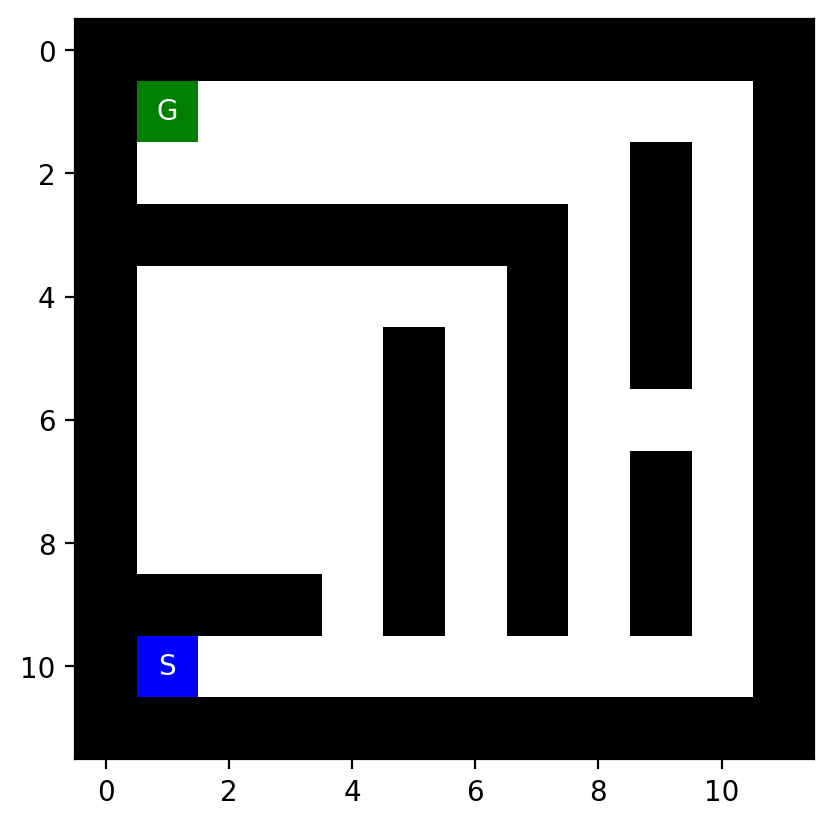

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (10, 1)
Goal location: (1, 1)


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [ ]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def __lt__(self, node):
        return self.cost < node.cost

    def h(self, n):
        return abs(self.pos[0] - n[0]) + abs(self.pos[1] - n[1])

    def f(self, n):
        return self.h(n) + self.cost

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
# Your answer goes here
'''
Initial state: All the spaces are either marked as S, G, X or unmarked.
The agent starts at location marked S on the maze map and wants
to reach location marked G. This is the goal that the agent wants to reach. All
the X's marked on the map represent a wall where the agent cannot go but the
agent can go through the empty/unmarked spaces.

Actions: The actions the agent can perform is move left, right, up or down.

Transition model: The action of move left, right, up or down moves the agent
one space towards the direction it is applied if the designated space is not
marked as X. If it is marked as X, then no action is taken.

Goal state: The goal location is marked as G.

Path cost: Each action costs 1
'''

"\n\n\nInitial state: All the spaces are either marked as S, G, X or unmarked. \nThe agent starts at location marked S on the maze map and wants \nto reach location marked G. This is the goal that the agent wants to reach. All \nthe X's marked on the map represent a wall where the agent cannot go but the \nagent can go through the empty/unmarked spaces.\n\nActions: The actions the agent can perform is move left, right, up or down.\n\nTransition model: The action of move left, right, up or down moves the agent \none space towards the direction it is applied if the designated space is not \nmarked as X. If it is marked as X, then no action is taken. \n\nGoal state: The goal location is marked as G.\n\nPath cost: Each action costs 1\n"

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
# Your answer goes here
'''
n = count number of unmarked spaces reachable from location S
d = calculate the mahattan distance of S and G
m = n because every empty space reachable from S can be reached in one branch
b = 4 because theres four directions you can potentially go
'''

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [59]:
# Your code goes here
from queue import Queue

def BFS(maze):
  nodes_expanded = 0
  max_tree_depth = 0
  max_nodes_in_mem = 1
  max_frontier_size = 0

  #initialize root node
  node = Node(mh.find_pos(maze, what = "S"), None, None, 0)
  #if S is at same location as G, return root node
  goal = mh.find_pos(maze, what = "G")
  start = mh.find_pos(maze, what = "S")
  if goal == start:
    return (node, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
  #initialize queue with root node in it
  frontier = Queue()
  frontier.put(node)
  #initialize reached list to keep track of which spaces have been visited
  reached = [start]

  #loop through frontier to find goal
  while not frontier.empty():
    #pop from queue
    node = frontier.get()
    nodes_expanded += 1

    if node.pos != start and node.pos != goal:
      maze[node.pos[0], node.pos[1]] = '.'
    #loop through the node's expanded children and search for goal
    for child in Expand(maze, node):
      #get state
      s = child.pos
      #check goal
      if goal == s:
        return (child, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
      #append to reached and frontier
      max_nodes_in_mem += 1
      if s not in reached:
        reached.append(s)
        frontier.put(child)
        if frontier.qsize() > max_frontier_size:
          max_frontier_size = frontier.qsize()
        if s != start and s != goal:
          maze[s[0], s[1]] = 'F'
        if child.cost > max_tree_depth:
          max_tree_depth = child.cost

  return (None, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

def DFS(maze):
  nodes_expanded = 0
  max_tree_depth = 0
  max_nodes_in_mem = 1
  max_frontier_size = 0

  #initialize root node
  source = Node(mh.find_pos(maze, what = "S"), None, None, 0)
  #if S is at same location as G, return root node
  goal = mh.find_pos(maze, what = "G")
  start = mh.find_pos(maze, what = "S")
  if goal == start:
    return (node, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
  #initialize stack with root node in it
  frontier = [source]
  parent = []

  #initialize reached list to keep track of which spaces have been visited
  # reached = [mh.find_pos(maze, what = "S")]

  #loop through frontier to find goal
  while frontier:
    #pop from queue
    node = frontier.pop()
    if node.pos != start and node.pos != goal:
      maze[node.pos[0], node.pos[1]] = '.'
    if node.pos in parent:
        return (None, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
    if node.parent:
      if node.parent.pos not in parent:
        parent.append(node.parent.pos)
      else:
        index = parent.index(node.parent.pos)
        parent = parent[:index + 1]
    nodes_expanded += 1
    # print(f"pop = {node}")
    #loop through the node's expanded children and search for goal
    for child in Expand(maze, node):
      #get state
      s = child.pos
      max_nodes_in_mem += 1
      #check goal
      if goal == s:
        return (child, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
      #append to frontier
      # print(f"child: {child}")
      # print(f"parent: {child.parent}")
      if s not in frontier:
        frontier.append(child)
        if s != start and s != goal:
          maze[s[0], s[1]] = 'F'
        if len(frontier) > max_frontier_size:
          max_frontier_size = len(frontier)
        if child.cost > max_tree_depth:
          max_tree_depth = child.cost
        # if source.pos == s:
        #   return (None, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

  return (None, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

def Expand(maze, node):
  #starting state
  s = node.pos
  #determine cost
  cost = node.cost + 1

  #moving left
  if mh.look(maze, (s[0] - 1, s[1])) != 'X':
    #create expanded node and yield
    if node.parent:
      if (s[0] - 1, s[1]) != node.parent.pos:
        yield Node((s[0] - 1, s[1]), node, "move up", cost)
    else:
      yield Node((s[0] - 1, s[1]), node, "move up", cost)
  #moving up
  if mh.look(maze, (s[0], s[1] + 1)) != 'X':
    #create expanded node and yield
    if node.parent:
      if (s[0], s[1] + 1) != node.parent.pos:
        yield Node((s[0], s[1] + 1), node, "move right", cost)
    else:
      yield Node((s[0], s[1] + 1), node, "move right", cost)
  #moving right
  if mh.look(maze, (s[0] + 1, s[1])) != 'X':
    #create expanded node and yield
    if node.parent:
      if (s[0] + 1, s[1]) != node.parent.pos:
        yield Node((s[0] + 1, s[1]), node, "move down", cost)
    else:
      yield Node((s[0] + 1, s[1]), node, "move down", cost)
  #moving down
  if mh.look(maze, (s[0], s[1] - 1)) != 'X':
    #create expanded node and yield
    if node.parent:
      if (s[0], s[1] - 1) != node.parent.pos:
        yield Node((s[0], s[1] - 1), node, "move left", cost)
    else:
      yield Node((s[0], s[1] - 1), node, "move left", cost)


# solution = BFS(maze)
# solution = DFS(maze)
# if solution:
#   path = solution.get_path_from_root()
#   for node in path:
#     print(node)
# else:
#   print("failed")

# mh.show_maze(maze)


How does BFS and DFS deal with loops (cycles)?

In [ ]:
# Discussion
'''
BFS will never be stuck in a loop since it expands all the nodes at the deepest
depth and all the nodes will only be expanded once. All nodes are also being
tracked if they are already visited by the reached data structure

As for DFS, since nodes are not being tracked if they are visited, you can only
keep track of the source node and during expanding the node, if the source node
is visited again, then we exit the search and return a failure. Visiting the
source node again would indicate a loop.
'''

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [ ]:
# Discussion
'''
My BFS implementation is complete because every space is visited at most once
and the deepest depth of the tree is fully explored before going to the next
depth. This ensures completeness by exploring one space ahead of the current
deepest depth and only go to the next depth until the whole depth is exlored.
If all the spaces are explored and the goal is not reached, then no node is
returned to indicate failure. BFS is optimal because it return the first goal
node found and this goal node should be the optimal path since all path cost is
1. The space complexity is O(4^d) where 4 is the maximum branching factor and d
is the depth of the optimal solution. The time complexity is also O(4^d) because
it will visit O(4^d) nodes and only visit all nodes until depth d.
The function Expand() is O(1) as it checks for if an action is valid and perform
it.

My DFS is incomplete because it can run into a loop and terminate in failure. It
is not optimal because it finds the "leftmost" solution. It uses the same
Expand() function as BFS. Space complexity is O(4m) where m is the maximum depth
and 4 is the maximum branching factor. Only neighbors of path are stored in stack.
Time complexity is O(4^m) because it could traverse the whole tree and can visit
a node more than once.
'''

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [46]:
# Your code goes here
from queue import PriorityQueue

def GBFS(maze):
  nodes_expanded = 0
  max_tree_depth = 0
  max_nodes_in_mem = 1
  max_frontier_size = 0

  #initialize root node
  node = Node(mh.find_pos(maze, what = "S"), None, None, 0)
  #if S is at same location as G, return root node
  goal = mh.find_pos(maze, what = "G")
  start = mh.find_pos(maze, what = "S")
  if goal == start:
    return (node, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
  #initialize queue with root node in it
  frontier = PriorityQueue()
  frontier.put((node.h(goal), node))
  #initialize reached list to keep track of which spaces have been visited
  reached = [start]

  #loop through frontier to find goal
  while not frontier.empty():
    #pop from queue
    heuristic, node = frontier.get()
    nodes_expanded += 1

    if node.pos != start and node.pos != goal:
      maze[node.pos[0], node.pos[1]] = '.'
    # print(node)
    #loop through the node's expanded children and search for goal
    for child in Expand(maze, node):
      #get state
      s = child.pos
      #check goal
      if goal == s:
        return (child, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

      max_nodes_in_mem += 1
      #append to reached and frontier
      if s not in reached:
        reached.append(s)
        # print(child)
        frontier.put((child.h(goal), child))
        if frontier.qsize() > max_frontier_size:
          max_frontier_size = frontier.qsize()
        if s != start and s != goal:
          maze[s[0], s[1]] = 'F'
        if child.cost > max_tree_depth:
          max_tree_depth = child.cost
        # print((child.h(goal), child))
        # print(goal)

  return (None, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

def AStar(maze):
  nodes_expanded = 0
  max_tree_depth = 0
  max_nodes_in_mem = 1
  max_frontier_size = 0

  #initialize root node
  node = Node(mh.find_pos(maze, what = "S"), None, None, 0)
  #if S is at same location as G, return root node
  goal = mh.find_pos(maze, what = "G")
  start = mh.find_pos(maze, what = "S")
  if goal == start:
    return (node, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)
  #initialize queue with root node in it
  frontier = PriorityQueue()
  frontier.put((node.f(goal), node))
  #initialize reached list to keep track of which spaces have been visited
  reached = [start]

  #loop through frontier to find goal
  while not frontier.empty():
    heuristic, node = frontier.get()
    nodes_expanded += 1

    if node.pos != start and node.pos != goal:
      maze[node.pos[0], node.pos[1]] = '.'
    #check goal
    if goal == node.pos:
      return (child, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

    #loop through the node's expanded children and search for goal
    for child in Expand(maze, node):
      #get state
      s = child.pos
      max_nodes_in_mem += 1
      #append to reached and frontier
      if s not in reached:
        reached.append(s)
        # print(child)
        frontier.put((child.f(goal), child))
        if frontier.qsize() > max_frontier_size:
          max_frontier_size = frontier.qsize()
        if s != start and s != goal:
          maze[s[0], s[1]] = 'F'
        if child.cost > max_tree_depth:
          max_tree_depth = child.cost
        # print((child.h(goal), child))
        # print(goal)

  return (None, nodes_expanded, max_tree_depth, max_nodes_in_mem, max_frontier_size)

# solution = GBFS(maze)
# solution = AStar(maze)
# if solution:
#   path = solution.get_path_from_root()
#   for node in path:
#     print(node)
# else:
#   print("failed")

# mh.show_maze(maze)


Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion
'''
Greedy Best-First search is complete because the maze is a finite search space.
A* search is complete because since we are using the mahattan distance for the
heuristic function, it will never over estimate the actual cost to reach the goal.
A* is optimal in this case as it is using an admissible heuristic function.
As for Greedy, an optimal solution is not always guarentee.
The space and time complexity of GBFS are O(|V|) because worst case, every node is
visited or stored. The time and space complexity of A* are O(4^d) where 4 is the maximum
branch factor and d is the depth of the optimal solution. Since the mahattan
distance is a admissible heuristic for the maze problem, the time complexity is
faster and the space complexity is smaller. Worst case doesn't need to search or
store the whole tree.
'''

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [68]:
# Add code
mazes = []

#0
with open("small_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Small Maze"))
#1
with open("medium_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Medium Maze"))
#2
with open("large_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Large Maze"))
#3
with open("open_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Open Maze"))
#4
with open("empty_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Empty Maze"))
#5
with open("empty_2_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Empty 2 Maze"))
#6
with open("wall_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Wall Maze"))
#7
with open("loops_maze.txt", "r") as f:
  maze_str = f.read()
  maze = mh.parse_maze(maze_str)
  mazes.append((maze, "Loops Maze"))

data = []

for maze in mazes:
  m1 = maze[0].copy()
  m2 = maze[0].copy()
  m3 = maze[0].copy()
  m4 = maze[0].copy()
  BFS_sol = BFS(m1)
  DFS_sol = DFS(m2)
  GBFS_sol = GBFS(m3)
  AStar_sol = AStar(m4)
  data.append(((BFS_sol, m1), (DFS_sol, m2), (GBFS_sol, m3), (AStar_sol, m4)))

# print(data)

# maze = mazes[3][0].copy()
# # mh.show_maze(maze)
# solution = BFS(maze)
# # solution = DFS(maze)
# # solution = GBFS(maze)
# # solution = AStar(maze)
# print(solution)
# if solution[0]:
#   path = solution[0].get_path_from_root()
#   for node in path:
#     print(node)
# else:
#   print("failed")

# mh.show_maze(maze)

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

In [71]:
# Add charts
import pandas as pd
import numpy as np

for num in range(8):
  print(mazes[num][1])
  # Create a DataFrame with the specified columns
  columns = ['Algorithm', 'Path Cost', '# of Nodes Expanded', 'Max Tree Depth', 'Max # of Nodes in Memory', 'Max Frontier Size']
  df = pd.DataFrame(columns=columns)

  #data[maze(0-7)][search algorrithm(0-3)][algorithm solution(0) or maze(1)][results(0-4)]
  chart = [
      ['BFS', data[num][0][0][0].cost if data[num][0][0][0] else "N/A*",
       data[num][0][0][1], data[num][0][0][2], data[num][0][0][3], data[num][0][0][4]],
      ['DFS', data[num][1][0][0].cost if data[num][1][0][0] else "N/A*",
       data[num][1][0][1], data[num][1][0][2], data[num][1][0][3], data[num][1][0][4]],
      ['GBS', data[num][2][0][0].cost if data[num][0][0][0] else "N/A*",
       data[num][2][0][1], data[num][2][0][2], data[num][2][0][3], data[num][2][0][4]],
      ['A*', data[num][3][0][0].cost if data[num][0][0][0] else "N/A*",
       data[num][3][0][1], data[num][3][0][2], data[num][3][0][3], data[num][3][0][4]],
  ]

  # Add the data to the DataFrame
  for row in chart:
      # df = df.append(pd.Series(row, index=df.columns), ignore_index=True)
      df = pd.concat([df, pd.DataFrame([row], columns=df.columns)], ignore_index=True)

  # Print the DataFrame
  print(df)




Small Maze
  Algorithm Path Cost # of Nodes Expanded Max Tree Depth  \
0       BFS        19                  90             19   
1       DFS        29                  39             28   
2       GBS        29                  39             28   
3        A*        19                  54             19   

  Max # of Nodes in Memory Max Frontier Size  
0                       96                 9  
1                       44                 5  
2                       43                 5  
3                       61                 8  
Medium Maze
  Algorithm Path Cost # of Nodes Expanded Max Tree Depth  \
0       BFS        68                 267             68   
1       DFS       152                 153            151   
2       GBS        74                  78             73   
3        A*        68                 222             68   

  Max # of Nodes in Memory Max Frontier Size  
0                      281                 9  
1                      161                 8  

Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.